In [23]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [13]:
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import albumentations as A

import os
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
IMG_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
MASK_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
test = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Test_Input'
testmask = '/kaggle/input/gfdgffd/ISIC2018_Task1_Test_GroundTruth (1)/ISIC2018_Task1_Test_GroundTruth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE= 16
SIZE = 224
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_WORKERS = 5
PIN_MEMORY = True

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

# -------------------------------------------
# Attention Modules (from Improved SwinUNet)
# -------------------------------------------
class LocalAttention(nn.Module):
    """Simple Local Attention using Depthwise Convolution."""
    def __init__(self, channels, kernel_size=3, padding=1):
        super(LocalAttention, self).__init__()
        self.attn = nn.Conv2d(channels, channels, kernel_size=kernel_size,
                              padding=padding, groups=channels, bias=True)
    def forward(self, x):
        return x * torch.sigmoid(self.attn(x))

class GlobalAttention(nn.Module):
    """Global Attention via Squeeze-and-Excitation."""
    def __init__(self, channels, reduction=16):
        super(GlobalAttention, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction, bias=False)
        self.fc2 = nn.Linear(channels // reduction, channels, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        b, c, _, _ = x.shape
        global_features = self.global_pool(x).view(b, c)
        attn_weights = self.sigmoid(self.fc2(F.relu(self.fc1(global_features))))
        return x * attn_weights.view(b, c, 1, 1)

# -------------------------------------------
# Skinformer Modules (Fusion & Enhancement)
# -------------------------------------------
class StatisticalTextureFusionTransformer(nn.Module):
    """
    Fuses multi-scale features via per-scale projection, gating,
    upsampling to a common resolution, and an MLP.
    """
    def __init__(self, in_channels_list, out_channels):
        super().__init__()
        self.proj = nn.ModuleList([
            nn.Conv2d(in_ch, out_channels, kernel_size=1) for in_ch in in_channels_list
        ])
        self.gates = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, 1),
                nn.Sigmoid()
            )
            for _ in in_channels_list
        ])
        self.mlp = nn.Sequential(
            nn.Conv2d(len(in_channels_list)*out_channels, out_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1)
        )
    def forward(self, features):
        fused = []
        for i, x in enumerate(features):
            proj_x = self.proj[i](x)
            gate_x = self.gates[i](proj_x)
            fused.append(proj_x * gate_x)
        # Upsample all fused features to the resolution of the first feature map
        ref = fused[0]
        B, C, H, W = ref.shape
        upsampled = [F.interpolate(feat, size=(H, W), mode='bilinear', align_corners=False)
                     for feat in fused]
        concat_feats = torch.cat(upsampled, dim=1)  # Shape: [B, len(features)*C, H, W]
        out = self.mlp(concat_feats)
        return out

class LocalWindowAttention(nn.Module):
    """
    Local-window self-attention: partitions the feature map into local windows,
    applies multi-head self-attention within each window, and merges them back.
    """
    def __init__(self, in_channels, window_size=7, num_heads=4):
        super().__init__()
        self.in_channels = in_channels
        self.window_size = window_size
        self.num_heads = num_heads
        self.head_dim = in_channels // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(in_channels, in_channels * 3)
        self.proj = nn.Linear(in_channels, in_channels)
        self.attn_drop = nn.Dropout(0.1)
    def forward(self, x):
        B, C, H, W = x.shape
        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        if pad_h or pad_w:
            x = F.pad(x, (0, pad_w, 0, pad_h))
        _, _, H_pad, W_pad = x.shape
        x = x.view(B, C, H_pad // self.window_size, self.window_size,
                   W_pad // self.window_size, self.window_size)
        x = x.permute(0, 2, 4, 3, 5, 1).contiguous()
        windows = x.view(-1, self.window_size * self.window_size, C)
        qkv = self.qkv(windows)
        qkv = qkv.reshape(windows.shape[0], windows.shape[1], 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = attn @ v
        out = out.transpose(1, 2).reshape(windows.shape[0], windows.shape[1], C)
        out = self.proj(out)
        out = out.view(B, H_pad // self.window_size, W_pad // self.window_size, self.window_size, self.window_size, C)
        out = out.permute(0, 5, 1, 3, 2, 4).contiguous().view(B, C, H_pad, W_pad)
        if pad_h or pad_w:
            out = out[:, :, :H, :W]
        return out

class ComprehensiveAttention(nn.Module):
    """
    Merges a local-window attention branch with a channel gate branch,
    then fuses them via an MLP.
    """
    def __init__(self, in_channels):
        super().__init__()
        self.local_attn = LocalWindowAttention(in_channels)
        self.channel_gate = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(in_channels, in_channels, 1),
            nn.Sigmoid()
        )
        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels * 2, in_channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=1)
        )
    def forward(self, x):
        attn_out = self.local_attn(x)
        gate = self.channel_gate(x)
        gated_x = x * gate
        merged = torch.cat([attn_out, gated_x], dim=1)
        out = self.mlp(merged)
        return out

class StatisticalTextureEnhanceTransformer(nn.Module):
    """
    Enhances fused features via dual-branch attention (Comprehensive and LocalWindow)
    and then refines via gating and an MLP.
    """
    def __init__(self, channels):
        super().__init__()
        self.c_attn = ComprehensiveAttention(channels)
        self.l_attn = LocalWindowAttention(channels)
        self.gate = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.mlp = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=1)
        )
    def forward(self, x):
        x_c = self.c_attn(x)
        x_l = self.l_attn(x)
        sum_feats = x_c + x_l
        g = self.gate(sum_feats)
        gated_sum = sum_feats * g
        out = self.mlp(gated_sum)
        return out

# -------------------------------------------
# Integrated Skinformer Network
# -------------------------------------------
class IntegratedSkinformerNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(IntegratedSkinformerNet, self).__init__()
        # Backbone: Swin Transformer with multi-scale feature extraction.
        # features_only=True returns a list of feature maps.
        self.backbone = timm.create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)
        # For swin_base, expected feature channels: [128, 256, 512, 1024]
        self.fusion = StatisticalTextureFusionTransformer(in_channels_list=[128, 256, 512, 1024],
                                                            out_channels=256)
        self.enhance = StatisticalTextureEnhanceTransformer(channels=256)
        # Additional refined attention modules
        self.global_attn = GlobalAttention(256)
        self.local_attn = LocalAttention(256)
        # Decoder: Progressive upsampling to produce segmentation mask.
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Extract multi-scale features using the backbone.
        features = self.backbone(x)
        # Convert features from NHWC to NCHW if necessary.
        expected_channels = [128, 256, 512, 1024]
        new_features = []
        for feat, exp in zip(features, expected_channels):
            if feat.ndim == 4 and feat.shape[1] != exp and feat.shape[-1] == exp:
                # Feature is likely in NHWC format; permute to NCHW.
                feat = feat.permute(0, 3, 1, 2)
            new_features.append(feat)
        features = new_features
        
        # Fuse the features.
        fused = self.fusion(features)  # [B, 256, H, W] (H, W: resolution of features[0])
        # Enhance fused features.
        enhanced = self.enhance(fused)  # [B, 256, H, W]
        # Further refine with global and local attention.
        enhanced = self.global_attn(enhanced)
        enhanced = self.local_attn(enhanced)
        # Decode: Upsample progressively.
        d1 = self.up1(enhanced)  # [B, 128, H*2, W*2]
        d2 = self.up2(d1)        # [B, 64, H*4, W*4]
        d3 = self.up3(d2)        # [B, 32, H*8, W*8]
        out = self.out_conv(d3)  # [B, out_channels, H*8, W*8]
        # Final upsample to match original input size.
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out

In [15]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.ids = [image_file[:-4] for image_file in os.listdir(images_path) if image_file.endswith('.jpg')]
        self.size = size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.ids[idx] + '.jpg')
        mask_path = os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png')
        
        # Load image and mask
        img = cv2.imread(os.path.join(self.images_path, self.ids[idx] + '.jpg'), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        
         # Convert to RGB, And convert mask to binary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']
        
        # Convert numpy arrays to PyTorch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        mask[mask == 255.0] = 1.0

        return img, mask

In [16]:
transform = A.Compose(
[
    A.Resize(height=SIZE, width=SIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1)
])

dataset = ISICDataset(images_path=IMG_PATH,
                            masks_path=MASK_PATH, size=SIZE, transform=transform)

dataset_test = ISICDataset(images_path=test,
                            masks_path=testmask, size=SIZE, transform=transform)

train_dataset = dataset
test_dataset = dataset_test

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


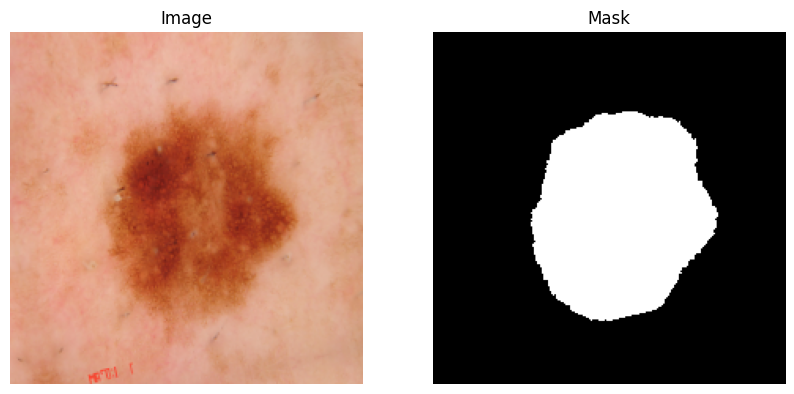

In [17]:
import matplotlib.pyplot as plt

# Get one batch from the test_loader
for imgs, masks in test_loader:
    # Convert the first image and mask to NumPy arrays
    img = imgs[0].permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC
    mask = masks[0].squeeze().cpu().numpy()  # Remove channel dim

    # Plot the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()
    break  # Stop after displaying one batch

In [18]:
model = IntegratedSkinformerNet(in_channels=3, out_channels=1).to(DEVICE)
model = model.to(memory_format=torch.channels_last)  # Optimize memory layout

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-18-d158acd6145a>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [19]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8
            
    print(f"Dice score: {dice_score/len(loader)}")

In [20]:
dataset_val=ISICDataset(images_path="/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input",masks_path="/kaggle/input/gfdgffd/ISIC2018_Task1_Validation_GroundTruth (1)/ISIC2018_Task1_Validation_GroundTruth",size=SIZE,transform=transform)

val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=0.2280, max=0.2299, mean=0.2292
Masks: min=0.0000, max=1.0000, mean=0.2710


Epoch 1: Train Loss = 0.3372, Val Loss = 0.2179
✅ Best model updated (Validation Loss: 0.2179)


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-11.4245, max=6.7602, mean=-5.2481
Masks: min=0.0000, max=1.0000, mean=0.1362


Epoch 2: Train Loss = 0.1242, Val Loss = 0.1188
✅ Best model updated (Validation Loss: 0.1188)


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-10.1441, max=6.7296, mean=-4.9933
Masks: min=0.0000, max=1.0000, mean=0.1885


Epoch 3: Train Loss = 0.1032, Val Loss = 0.1388


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-10.2329, max=9.0406, mean=-2.4038
Masks: min=0.0000, max=1.0000, mean=0.2886


Epoch 4: Train Loss = 0.0959, Val Loss = 0.1233


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-12.2411, max=11.5150, mean=-6.9500
Masks: min=0.0000, max=1.0000, mean=0.1136


Epoch 5: Train Loss = 0.0930, Val Loss = 0.1706


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-11.4600, max=12.8848, mean=-4.8502
Masks: min=0.0000, max=1.0000, mean=0.1604


Epoch 6: Train Loss = 0.0881, Val Loss = 0.1598


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-12.5039, max=12.3172, mean=-3.7358
Masks: min=0.0000, max=1.0000, mean=0.3108


Epoch 7: Train Loss = 0.0807, Val Loss = 0.1403


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-14.7188, max=10.7774, mean=-4.9920
Masks: min=0.0000, max=1.0000, mean=0.2454


Epoch 8: Train Loss = 0.0804, Val Loss = 0.1479


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-16.1855, max=12.8965, mean=-5.7641
Masks: min=0.0000, max=1.0000, mean=0.2587


Epoch 9: Train Loss = 0.0763, Val Loss = 0.1005
✅ Best model updated (Validation Loss: 0.1005)


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-14.8564, max=15.3389, mean=-7.4729
Masks: min=0.0000, max=1.0000, mean=0.1742


Epoch 10: Train Loss = 0.0721, Val Loss = 0.1689


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-16.1102, max=14.0833, mean=-7.6933
Masks: min=0.0000, max=1.0000, mean=0.1791


Epoch 11: Train Loss = 0.0695, Val Loss = 0.1533


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-13.4030, max=13.7780, mean=-5.6746
Masks: min=0.0000, max=1.0000, mean=0.1628


Epoch 12: Train Loss = 0.0663, Val Loss = 0.1611


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-15.4785, max=14.9695, mean=-6.6049
Masks: min=0.0000, max=1.0000, mean=0.1779


Epoch 13: Train Loss = 0.0653, Val Loss = 0.1279


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-15.1042, max=16.2336, mean=-6.5366
Masks: min=0.0000, max=1.0000, mean=0.1815


Epoch 14: Train Loss = 0.0622, Val Loss = 0.1179


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-15.8474, max=15.0625, mean=-7.2629
Masks: min=0.0000, max=1.0000, mean=0.1554


Epoch 15: Train Loss = 0.0615, Val Loss = 0.1550


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-17.3750, max=16.9252, mean=-6.7100
Masks: min=0.0000, max=1.0000, mean=0.2361


Epoch 16: Train Loss = 0.0598, Val Loss = 0.1806


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-19.1666, max=16.3031, mean=-7.1056
Masks: min=0.0000, max=1.0000, mean=0.2213


Epoch 17: Train Loss = 0.0576, Val Loss = 0.1899


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-17.7477, max=17.4500, mean=-7.2061
Masks: min=0.0000, max=1.0000, mean=0.2043


Epoch 18: Train Loss = 0.0548, Val Loss = 0.1730


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-19.0634, max=17.5874, mean=-6.8845
Masks: min=0.0000, max=1.0000, mean=0.2262


Epoch 19: Train Loss = 0.0561, Val Loss = 0.1849


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-22.4521, max=15.5910, mean=-10.7969
Masks: min=0.0000, max=1.0000, mean=0.1495


Epoch 20: Train Loss = 0.0524, Val Loss = 0.1844


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-21.0475, max=18.2724, mean=-6.1531
Masks: min=0.0000, max=1.0000, mean=0.2725


Epoch 21: Train Loss = 0.0511, Val Loss = 0.1659


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-18.2823, max=20.0892, mean=-8.1307
Masks: min=0.0000, max=1.0000, mean=0.1877


Epoch 22: Train Loss = 0.0501, Val Loss = 0.1491


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-17.5022, max=21.5704, mean=-6.1662
Masks: min=0.0000, max=1.0000, mean=0.2038


Epoch 23: Train Loss = 0.0508, Val Loss = 0.1594


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-22.5303, max=20.9472, mean=-8.2307
Masks: min=0.0000, max=1.0000, mean=0.2060


Epoch 24: Train Loss = 0.0510, Val Loss = 0.1718


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-21.4876, max=17.8095, mean=-9.0025
Masks: min=0.0000, max=1.0000, mean=0.1529


Epoch 25: Train Loss = 0.0481, Val Loss = 0.1232


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-20.8596, max=18.6550, mean=-8.4412
Masks: min=0.0000, max=1.0000, mean=0.1692


Epoch 26: Train Loss = 0.0468, Val Loss = 0.1897


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-20.0182, max=17.4434, mean=-6.9494
Masks: min=0.0000, max=1.0000, mean=0.2059


Epoch 27: Train Loss = 0.0460, Val Loss = 0.1565


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-20.7004, max=19.7500, mean=-6.8284
Masks: min=0.0000, max=1.0000, mean=0.2461


Epoch 28: Train Loss = 0.0429, Val Loss = 0.1358


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-22.2421, max=16.2834, mean=-7.5843
Masks: min=0.0000, max=1.0000, mean=0.2855


Epoch 32: Train Loss = 0.0414, Val Loss = 0.1606


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-25.5078, max=13.1173, mean=-11.4590
Masks: min=0.0000, max=1.0000, mean=0.1656


Epoch 33: Train Loss = 0.0413, Val Loss = 0.1551


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-22.7736, max=18.2955, mean=-9.8322
Masks: min=0.0000, max=1.0000, mean=0.1834


Epoch 34: Train Loss = 0.0390, Val Loss = 0.1648


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-24.4583, max=20.3827, mean=-8.6089
Masks: min=0.0000, max=1.0000, mean=0.2016


Epoch 35: Train Loss = 0.0378, Val Loss = 0.1763


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-26.1246, max=24.1526, mean=-8.0911
Masks: min=0.0000, max=1.0000, mean=0.2697


Epoch 36: Train Loss = 0.0375, Val Loss = 0.1774


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-23.0810, max=22.6784, mean=-8.9416
Masks: min=0.0000, max=1.0000, mean=0.1874


Epoch 37: Train Loss = 0.0388, Val Loss = 0.1682


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-25.2937, max=21.4969, mean=-10.9519
Masks: min=0.0000, max=1.0000, mean=0.1742


Epoch 38: Train Loss = 0.0369, Val Loss = 0.1934


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-25.9369, max=22.3543, mean=-11.9370
Masks: min=0.0000, max=1.0000, mean=0.1330


Epoch 39: Train Loss = 0.0363, Val Loss = 0.1517


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.7188, max=22.6299, mean=-13.7316
Masks: min=0.0000, max=1.0000, mean=0.1065


Epoch 40: Train Loss = 0.0359, Val Loss = 0.1755


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-24.3243, max=23.1249, mean=-7.1768
Masks: min=0.0000, max=1.0000, mean=0.2528


Epoch 41: Train Loss = 0.0349, Val Loss = 0.1652


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-23.5854, max=21.5923, mean=-9.1215
Masks: min=0.0000, max=1.0000, mean=0.1972


Epoch 42: Train Loss = 0.0355, Val Loss = 0.1666


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-26.0480, max=27.6639, mean=-8.6049
Masks: min=0.0000, max=1.0000, mean=0.1990


Epoch 43: Train Loss = 0.0345, Val Loss = 0.1620


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.8306, max=23.5950, mean=-12.8399
Masks: min=0.0000, max=1.0000, mean=0.1632


Epoch 44: Train Loss = 0.0337, Val Loss = 0.2105


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.2461, max=25.6274, mean=-9.6767
Masks: min=0.0000, max=1.0000, mean=0.2222


Epoch 45: Train Loss = 0.0348, Val Loss = 0.1686


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-27.2138, max=19.5699, mean=-10.4829
Masks: min=0.0000, max=1.0000, mean=0.2391


Epoch 46: Train Loss = 0.0339, Val Loss = 0.2868


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.9517, max=22.5981, mean=-11.2213
Masks: min=0.0000, max=1.0000, mean=0.2027


Epoch 47: Train Loss = 0.0363, Val Loss = 0.2885


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-29.3449, max=25.8408, mean=-10.4844
Masks: min=0.0000, max=1.0000, mean=0.2166


Epoch 48: Train Loss = 0.0337, Val Loss = 0.1635


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-24.8354, max=23.1655, mean=-8.5063
Masks: min=0.0000, max=1.0000, mean=0.2039


Epoch 49: Train Loss = 0.0331, Val Loss = 0.2488


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.3870, max=23.7418, mean=-11.8401
Masks: min=0.0000, max=1.0000, mean=0.1395


Epoch 50: Train Loss = 0.0320, Val Loss = 0.2530


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-32.1056, max=23.1105, mean=-10.3464
Masks: min=0.0000, max=1.0000, mean=0.1929


Epoch 51: Train Loss = 0.0335, Val Loss = 0.2472


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-25.9957, max=21.7907, mean=-7.1275
Masks: min=0.0000, max=1.0000, mean=0.2549


Epoch 52: Train Loss = 0.0322, Val Loss = 0.1583


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-27.6397, max=21.5241, mean=-13.3314
Masks: min=0.0000, max=1.0000, mean=0.1015


Epoch 53: Train Loss = 0.0312, Val Loss = 0.2890


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-26.5101, max=24.6152, mean=-7.9732
Masks: min=0.0000, max=1.0000, mean=0.2751


Epoch 54: Train Loss = 0.0310, Val Loss = 0.1973


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-29.9403, max=22.8251, mean=-10.3051
Masks: min=0.0000, max=1.0000, mean=0.2090


Epoch 55: Train Loss = 0.0301, Val Loss = 0.2005


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-29.0582, max=23.6159, mean=-10.7180
Masks: min=0.0000, max=1.0000, mean=0.2044


Epoch 56: Train Loss = 0.0296, Val Loss = 0.2324


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-27.2840, max=27.5971, mean=-9.0848
Masks: min=0.0000, max=1.0000, mean=0.2424


Epoch 57: Train Loss = 0.0297, Val Loss = 0.2263


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.4587, max=26.1222, mean=-9.2188
Masks: min=0.0000, max=1.0000, mean=0.2216


Epoch 58: Train Loss = 0.0299, Val Loss = 0.1927


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-28.8761, max=29.9942, mean=-10.1708
Masks: min=0.0000, max=1.0000, mean=0.2370


Epoch 59: Train Loss = 0.0289, Val Loss = 0.2584


  0%|          | 0/163 [00:00<?, ?it/s]

Outputs: min=-27.5012, max=31.4740, mean=-9.0930
Masks: min=0.0000, max=1.0000, mean=0.2347


Epoch 60: Train Loss = 0.0289, Val Loss = 0.1754


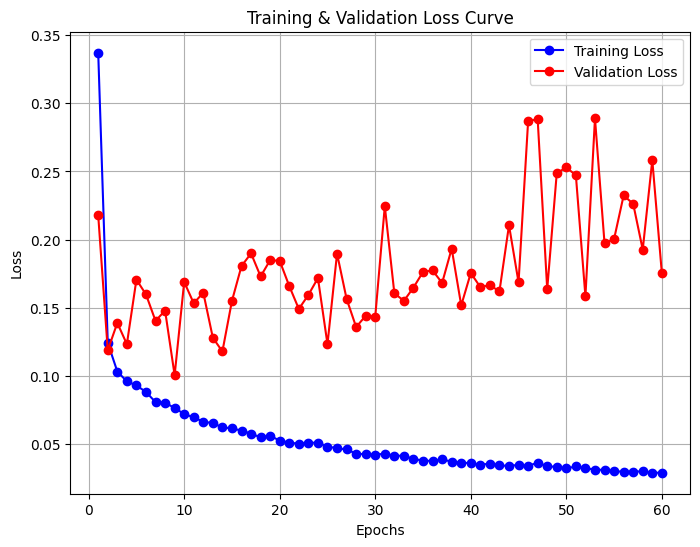

In [33]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

NUM_EPOCHS = 60  # Define number of epochs
train_loss_history = []  # Store training loss
val_loss_history = []    # Store validation loss
best_val_loss = float('inf')  # Track the lowest validation loss

# Option: Lower your learning rate further (e.g., 1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Uncomment if needed

for epoch in range(NUM_EPOCHS):
    torch.autograd.set_detect_anomaly(True)
    model.train()  # Set model to training mode
    epoch_train_loss = 0  
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    for batch_idx, (images, masks) in loop:
        images, masks = images.to(DEVICE).float(), masks.to(DEVICE).float()
        
        # Ensure target masks are within [0, 1]
        masks = torch.clamp(masks, 0, 1)

        optimizer.zero_grad()

        # Try disabling AMP temporarily for debugging (set enabled=False)
        with torch.amp.autocast(device_type='cuda', enabled=False):
            outputs = model(images)
            # Optionally log statistics
            if batch_idx == 0:
                print(f"Outputs: min={outputs.min().item():.4f}, max={outputs.max().item():.4f}, mean={outputs.mean().item():.4f}")
                print(f"Masks: min={masks.min().item():.4f}, max={masks.max().item():.4f}, mean={masks.mean().item():.4f}")
            # Clamp outputs to prevent extreme logits causing numerical instability
            outputs = torch.clamp(outputs, -15, 15)
            loss = criterion(outputs, masks)
            
        # Check if loss is NaN immediately after loss computation
        if torch.isnan(loss):
            print(f"NaN loss detected before backward at epoch {epoch+1}, batch {batch_idx}")
            # Optionally: break or save model state for inspection
            break

        # Backward pass with gradient scaling and clipping
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()

        epoch_train_loss += loss.item()
        loop.set_description(f"Epoch[{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(train_loss=loss.item())

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    model.eval()  # Set model to evaluation mode
    epoch_val_loss = 0  
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE).float(), masks.to(DEVICE).float()
            masks = torch.clamp(masks, 0, 1)
            outputs = model(images)
            outputs = torch.clamp(outputs, -15, 15)
            loss = criterion(outputs, masks)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_checkpoint = "best_model.pth.tar"
        torch.save({'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}, best_checkpoint)
        print(f"✅ Best model updated (Validation Loss: {best_val_loss:.4f})")
    torch.cuda.empty_cache()

plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_loss_history, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
checkpoint_path = "best_model.pth.tar"

# Load checkpoint
checkpoint = torch.load("/kaggle/working/best_model.pth.tar", map_location="cuda")

# Load weights into the model
model.load_state_dict(checkpoint['state_dict'])
model.to("cuda")

<ipython-input-34-b84bf0c0f980>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/best_model.pth.tar", map_location="cuda")


IntegratedSkinformerNet(
  (backbone): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(appr

In [35]:
dice_score = check_accuracy(test_loader, model, device="cuda")

Dice score: 0.8999620676040649


In [36]:
dice_score_val = check_accuracy(val_loader, model, device="cuda")

Dice score: 0.9158423542976379


In [37]:
dice_score_train = check_accuracy(train_loader, model, device="cuda")

Dice score: 0.9260495901107788


In [2]:
pip install fpdf

  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=9e43708016b8d469d65cff571fd65ddd199af2927a07b35609815ab698207187
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
Note: you may need to restart the kernel to use updated packages.


In [46]:
checkpoint_path = "best_model.pth.tar"

# Load checkpoint
checkpoint = torch.load("/kaggle/input/best/pytorch/default/1/best_model.pth.tar", map_location=torch.device('cpu'))

# Load weights into the model
model.load_state_dict(checkpoint['state_dict'])
model.to("cpu")
model.eval()

<ipython-input-46-dfa4fa481c2b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/input/best/pytorch/default/1/best_model.pth.tar", map_locat

IntegratedSkinformerNet(
  (backbone): FeatureListNet(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers_0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(appr

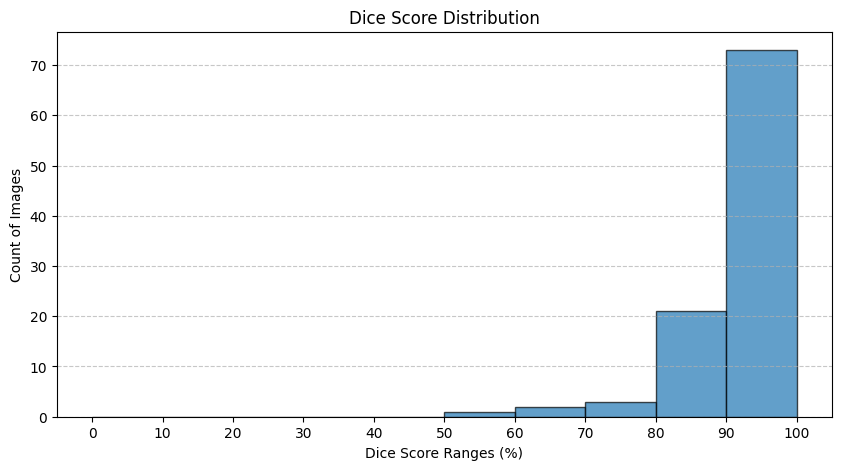

Dice Scores for Each Image:
ISIC_0017341: 93.24%
ISIC_0015480: 95.81%
ISIC_0015518: 95.84%
ISIC_0021914: 92.28%
ISIC_0017755: 93.50%
ISIC_0012627: 76.69%
ISIC_0020861: 94.09%
ISIC_0018179: 89.93%
ISIC_0024135: 94.18%
ISIC_0018248: 96.36%
ISIC_0022029: 91.28%
ISIC_0036101: 93.64%
ISIC_0021202: 93.62%
ISIC_0023508: 97.61%
ISIC_0018472: 97.28%
ISIC_0012623: 91.75%
ISIC_0023755: 86.61%
ISIC_0021449: 92.56%
ISIC_0015370: 97.91%
ISIC_0036237: 97.78%
ISIC_0019309: 98.51%
ISIC_0018680: 89.22%
ISIC_0023678: 91.38%
ISIC_0018556: 97.26%
ISIC_0020233: 96.47%
ISIC_0019334: 95.21%
ISIC_0012585: 95.47%
ISIC_0021448: 90.60%
ISIC_0036247: 68.89%
ISIC_0036328: 81.07%
ISIC_0020418: 93.21%
ISIC_0016351: 88.89%
ISIC_0018375: 94.52%
ISIC_0023924: 87.47%
ISIC_0036291: 91.83%
ISIC_0019883: 91.53%
ISIC_0017460: 97.61%
ISIC_0017474: 97.87%
ISIC_0017399: 97.65%
ISIC_0036306: 87.91%
ISIC_0023628: 92.64%
ISIC_0036147: 89.94%
ISIC_0021714: 70.79%
ISIC_0023831: 93.47%
ISIC_0022221: 81.86%
ISIC_0023936: 87.49%
ISIC_0

In [47]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# -------------------------
# 1. Define the Custom Dataset (Modified to include resizing and return image ID)
# -------------------------
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        """
        images_path: directory of input images.
        masks_path: directory of corresponding masks.
        size: desired size as (width, height) for resizing (e.g., (224, 224)).
        transform: optional additional transform.
        """
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        # Get image IDs from jpg files (remove the '.jpg' extension)
        self.ids = [f[:-4] for f in os.listdir(images_path) if f.endswith('.jpg')]
        self.size = size  # (width, height)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image_path = os.path.join(self.images_path, img_id + '.jpg')
        mask_path = os.path.join(self.masks_path, img_id + '_segmentation.png')
        
        # Load image and mask
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Resize to desired size (cv2.resize expects (width, height))
        img = cv2.resize(img, self.size)
        mask = cv2.resize(mask, self.size, interpolation=cv2.INTER_NEAREST)
        
        # Convert to RGB and threshold mask to binary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        # Convert numpy arrays to PyTorch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        mask[mask == 255.0] = 1.0
        
        return img_id, img, mask

# -------------------------
# 2. Define the Dice Score Function
# -------------------------
def dice_coefficient(y_true, y_pred):
    """
    Computes the Dice coefficient between two binary masks.
    Expects y_true and y_pred as numpy arrays with values 0 or 1.
    """
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-8)

# -------------------------
# 3. Setup Paths, Model, and DataLoader
# -------------------------
# Update these paths as needed:
validation_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input"
mask_path = "/kaggle/input/gfdgffd/ISIC2018_Task1_Validation_GroundTruth (1)/ISIC2018_Task1_Validation_GroundTruth"

# Set the desired input size for the model (width, height)
input_size = (224, 224)

# Create dataset and dataloader
dataset = ISICDataset(validation_path, mask_path, size=input_size, transform=None)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# -------------------------
# 4. Process Validation Data and Compute Dice Scores (with image IDs)
# -------------------------
dice_scores = []  # To store dice scores (in percentage)
image_ids = []   # To store corresponding image IDs

for img_id, img, mask in data_loader:
    image_ids.append(img_id[0])  # Save image ID (string)
    img = img.to(device)
    
    # Convert ground truth mask to numpy (expected shape: H x W)
    gt_mask = mask.cpu().numpy().squeeze(0)
    
    # Predict the mask with the model
    with torch.no_grad():
        output = model(img)
        pred_mask = torch.sigmoid(output).cpu().numpy().squeeze(0)
    
    # If prediction has an extra dimension, squeeze it
    if pred_mask.ndim == 3:
        pred_mask = np.squeeze(pred_mask)
    
    # Threshold prediction to obtain binary mask (0 or 1)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Compute Dice score for this image and store (as percentage)
    dice = dice_coefficient(gt_mask, pred_mask)
    dice_scores.append(dice * 100)

# -------------------------
# 5. Generate and Save the Bar Graph
# -------------------------
# Define bins for ranges: 0-10%, 10-20%, ..., 90-100%
bins = list(range(0, 110, 10))

plt.figure(figsize=(10, 5))
plt.hist(dice_scores, bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Dice Score Ranges (%)")
plt.ylabel("Count of Images")
plt.title("Dice Score Distribution")
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.7)

bar_graph_file = "/kaggle/working/Dice_Score_Distribution.png"
plt.savefig(bar_graph_file)
plt.show()

print("Dice Scores for Each Image:")
for img_id, score in zip(image_ids, dice_scores):
    print(f"{img_id}: {score:.2f}%")
    
print(f"\nBar graph saved as {bar_graph_file}")


In [48]:
temp_dir = "/kaggle/temp"
os.makedirs(temp_dir, exist_ok=True)

# Create PDF object
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)

# -------------------------
# 5. Process Validation Data, Compute Metrics, and Build PDF
# -------------------------
for img_id, img, mask in data_loader:
    # Save image ID
    current_id = img_id[0]
    
    # Move image to device
    img = img.to(device)
    
    # Convert ground truth mask to numpy (shape: H x W)
    gt_mask = mask.cpu().numpy().squeeze(0)
    
    # Predict mask using model
    with torch.no_grad():
        output = model(img)
        pred_mask = torch.sigmoid(output).cpu().numpy().squeeze(0)
    
    # If prediction has extra dimensions, squeeze it
    if pred_mask.ndim == 3:
        pred_mask = np.squeeze(pred_mask)
    
    # Threshold prediction to obtain binary mask (0 or 1)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Compute Dice score for this image
    dice = dice_coefficient(gt_mask, pred_mask)
    
    # Convert tensors and masks to proper image format for saving
    # Original image: convert tensor (C,H,W) to numpy (H,W,3)
    img_np = img.cpu().numpy().squeeze().transpose(1, 2, 0)
    img_np = (img_np * 255).astype(np.uint8)
    
    # Ground truth and predicted masks (scale to 0-255)
    gt_np = (gt_mask * 255).astype(np.uint8)
    pred_np = (pred_mask * 255).astype(np.uint8)
    
    # Ensure masks are 2D arrays (H x W)
    if gt_np.ndim == 3:
        gt_np = np.squeeze(gt_np)
    if pred_np.ndim == 3:
        pred_np = np.squeeze(pred_np)
    
    # Save temporary images
    img_save_path = os.path.join(temp_dir, f"{current_id}_img.jpg")
    gt_save_path = os.path.join(temp_dir, f"{current_id}_gt.jpg")
    pred_save_path = os.path.join(temp_dir, f"{current_id}_pred.jpg")
    
    # Note: cv2.imwrite expects BGR format for color images
    cv2.imwrite(img_save_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
    cv2.imwrite(gt_save_path, gt_np)
    cv2.imwrite(pred_save_path, pred_np)
    
    # Add a new page to the PDF
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, f"Image ID: {current_id}", ln=True, align='C')
    
    # Add images to the PDF. Adjust x,y coordinates and width (w) as needed.
    # Here, we place them side by side: Original, Ground Truth, and Predicted Mask.
    pdf.image(img_save_path, x=10, y=30, w=60)
    pdf.image(gt_save_path, x=80, y=30, w=60)
    pdf.image(pred_save_path, x=150, y=30, w=60)
    
    # Move to next line and add the Dice score
    pdf.ln(75)
    pdf.cell(0, 10, f"Dice Score: {dice * 100:.2f}%", ln=True, align='C')

# -------------------------
# 6. Save the PDF Report
# -------------------------
pdf_file = "/kaggle/working/Segmentation_Results.pdf"
pdf.output(pdf_file)
print(f"PDF report saved as {pdf_file}")

PDF report saved as /kaggle/working/Segmentation_Results.pdf


In [49]:
results = []  # List to store metrics for each image

for img_id, img, mask in data_loader:
    current_id = img_id[0]  # Extract image ID (string)
    img = img.to(device)
    
    # Convert ground truth mask to numpy array; shape: (H, W)
    gt_mask = mask.cpu().numpy().squeeze(0)
    
    # Get predicted mask from model
    with torch.no_grad():
        output = model(img)
        pred_mask = torch.sigmoid(output).cpu().numpy().squeeze(0)
    
    # Remove extra dimensions if needed
    if pred_mask.ndim == 3:
        pred_mask = np.squeeze(pred_mask)
    
    # Threshold prediction to obtain a binary mask (0 or 1)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    
    # Compute metrics
    dice = dice_coefficient(gt_mask, pred_mask)
    jacard = jaccard_score(gt_mask.flatten(), pred_mask.flatten(), average="binary")
    sensitivity, specificity = sensitivity_specificity(gt_mask, pred_mask)
    
    # Append metrics for current image: Image ID, Specificity, Sensitivity, Jaccard Index, Dice Score
    results.append([current_id, specificity, sensitivity, jacard, dice])

# -------------------------
# 5. Save the Metrics to an Excel File
# -------------------------
df = pd.DataFrame(results, columns=["Image ID", "Specificity", "Sensitivity", "Jaccard Index", "Dice Score"])
excel_file = "/kaggle/working/Segmentation_Metrics.xlsx"
df.to_excel(excel_file, index=False)
print(f"Excel file saved as {excel_file}")

Excel file saved as /kaggle/working/Segmentation_Metrics.xlsx
